In [2]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

# Data access

In [61]:
runnr = 98
base_path = '/Volumes/Duane1/amol3416/pbcv/'
filename_ol1 = base_path + 'amol3416_r%04d_ol1.h5' %runnr
filename_ol3 = base_path + 'amol3416_r%04d_ol3.h5' %runnr
filename_sizing = base_path + 'sizing/amol3416_r%04d_sizing.h5' %runnr

# Hit-finding

The overall hitrate for run 98 is 15.1% (10581 hits)


<IPython.core.display.Javascript object>


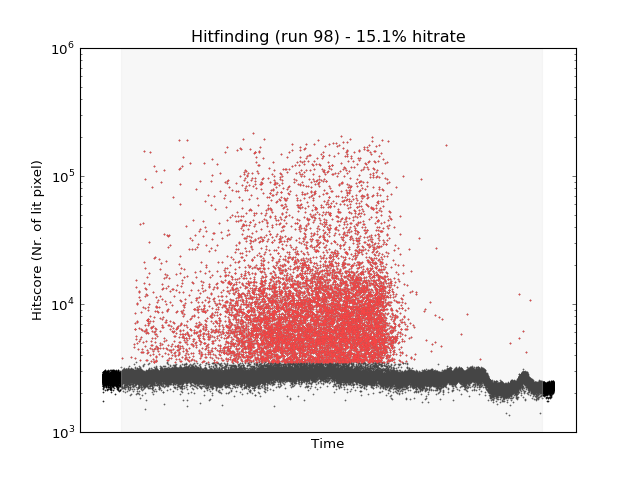

In [62]:
# Loading hitscore for output level 1 (all events)
with h5py.File(filename_ol1, 'r') as f:
    timestamp_all = f['entry_1/event/timestamp'][:]
    hitscore_all  = f['entry_1/result_1/hitscore_litpixel'][:]

# Loading hitscore for output level 3 (all hits)
with h5py.File(filename_ol3, 'r') as f:
    timestamp_hits = f['entry_1/event/timestamp'][:]
    hitscore_hits = f['entry_1/result_1/hitscore_litpixel'][:]
    hitscore_threshold = f['entry_1/result_1/hitscore_litpixel_threshold'][0]

# Time limits
time_limits = {}
time_limits['0098'] = [3000,-1000]
time_limits['0100'] = [0,13000]
tmin = timestamp_all[time_limits['%04d' %runnr][0]]
tmax = timestamp_all[time_limits['%04d' %runnr][1]]

# Valid (within time limits)
valid_all  = (timestamp_all > tmin) & (timestamp_all < tmax)
valid_hits = (timestamp_hits > tmin) & (timestamp_hits < tmax)

# Calculate overall hitrate
hitrate = float(valid_hits.sum()) / valid_all.sum() * 100
print "The overall hitrate for run %d is %.1f%% (%d hits)" %(runnr, hitrate, valid_hits.sum())
    
# Plotting hitscore and threshold
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_title('Hitfinding (run %d) - %.1f%% hitrate' %(runnr, hitrate))
ax.scatter(timestamp_all,  hitscore_all,  color='k', s=1, marker='.')
ax.scatter(timestamp_hits, hitscore_hits, color='r', s=1, marker='.')
ax.axvspan(tmin, tmax, alpha=0.3, color='0.9')
ax.set_xticks([])
ax.set_xlabel('Time')
ax.set_ylabel('Hitscore (Nr. of lit pixel)')
ax.semilogy()
plt.show()

# Experimental parameters

In [63]:
# Load parameters from file
with h5py.File(filename_ol3, 'r') as f:
    photon_energy_ev = f['entry_1/FEL/photon_energy_eV_SLAC'][:]
    wavelength_nm    = f['entry_1/FEL/wavelength_nm_SLAC'][:]
    pulse_energy_mJ  = f['entry_1/detector_3/pulse_energy_mJ'][:]
print "Run %d has photon energy of (mean/std): %.2f/%.2f eV" %(runnr, photon_energy_ev.mean(), photon_energy_ev.std())
print "Run %d has pulse  energy of (mean/std): %.2f/%.2f mJ" %(runnr, pulse_energy_mJ.mean(), pulse_energy_mJ.std())

Run 98 has photon energy of (mean/std): 777.97/0.77 eV
Run 98 has pulse  energy of (mean/std): 2.43/0.07 mJ
